In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus= tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)   # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V2_branched import *
import aux_func_numpy as debug

float_pres = 'float64' # Definindo a precisão padrão para as análises

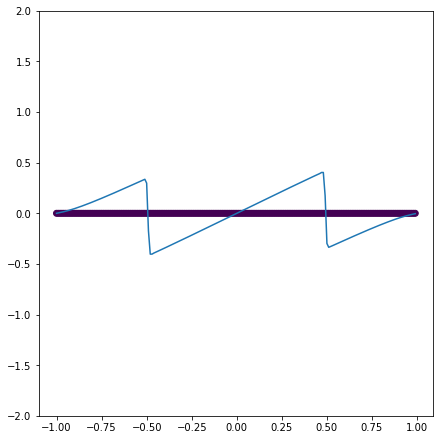

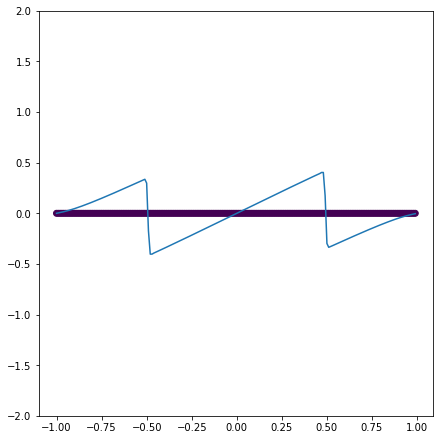

In [3]:
# Visualizando os resultados

Δx = 0.01                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional


# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# # Função definida no artigo
# f_test = lambda x: -tf.math.sin(np.pi*x) - 0.5 * x**3 + \
#     tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres))

# u = f_test(x) # Obtendo a condição inicial a partir de f_test

# u=tf.expand_dims(u,axis=0)
# u=tf.expand_dims(u,axis=2)
# u_Z=u[:]
#-------------------------------------------------------------------------------------------

# Condição inicial fixada
#----------------------------------------------------------------------
k1 = 5    # Frequência para a função seno
k2 = 2    # Frequência para a função seno
a  = 0.25 # Peso para ponderar as funções seno
b  = 0.75 # Modificador de amplitude

# Função que gera pontos de acordo com a primeira função seno
u1 = lambda x:     a * tf.expand_dims(tf.math.sin(k1*pi*x), axis=1)
# Função que gera pontos de acordo com a segunda função seno
u2 = lambda x: (1-a) * tf.expand_dims(tf.math.sin(k2*pi*x), axis=1)
# Obtendo a condição inicial a partir das funções senos
u  = b*(u1(x)+u2(x))

u   = tf.expand_dims(u, axis=0) # Acrescentando uma dimensão
u_Z = u[:]                      # u do artigo
#-----------------------------------------------------------------------

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T = 1     # Instante de tempo final
t = 0.0   # Instante de tempo inicial

# Gerando os gráficos a partir de funções do matplotlib

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax  = fig.add_subplot(1, 1, 1)
ax.set_ylim(-2, 2)
# ax.set_xlim(0,1)
line = ax.plot(x, tf.squeeze(u))
hfig = display(fig, display_id=True)

t = 0.0

while t < T:
    
    Δt_max = T-t # Tempo restante até T
    
    # Valor utilizado para obter o Δt
    Λ   = tf.math.reduce_max(tf.abs(u_Z), axis=1, keepdims=True)
    # Obtendo o valor de Δt a partir de CFL
    Δt  = Δx*CFL/Λ
    # Caso o passo temporal utrapasse o valor de Δt_max então o 
    # tamanho do passo se torna Δt_max
    Δt  = tf.where(Δt > Δt_max, Δt_max,Δt)
    
    # Saída de Burgers (aqui costuma-se utilizar a equação do transporte)
    u_Z, index = Burgers(u_Z, Δt, Δx, CFL, FronteiraPeriodica) 
    squeezed_u = tf.squeeze(u_Z) # Reduzindo dimensões redundantes
    
    t += Δt # Avançando no tempo
    
    print('t: ',tf.squeeze(t).numpy(),'                                ',end='\r')
    
color = tf.gather([0, 1], tf.cast(tf.squeeze(index), tf.int32)).numpy()

# Exibindo graficamente os valores obtidos
ax.scatter(x, np.zeros([x.shape[0]]), c = color)
line[0].set_ydata(squeezed_u.numpy())

fig.canvas.draw()
hfig.update(fig)
